# **SUMMARY**

<div class="alert alert-block alert-success">
<b>Adding Monet-like style to photographs with GANs:</b>
    
***

* a generative adversarial network was trained on a set of photographs and Monet paintings
* randomly sampled image batches of size one, 128 batches of each photos and paintings used _per_ epoch, 20 training epochs
* a generator (UNET-like architecture with downsampling convolutions instead of maxsampling) was trained to generate Monet-like paintings from either photographs or real Monet paintings
* an adversary (discriminator) was trained to correctly identify generated images and real paintings (binary cross-entropy)
* the generator learns how to produce better Monet's from how well it can cheat the adversary with a generated Monet
* work in progress
</div>

<div class="alert alert-block alert-info">
<b>Notes:</b>

* different batch sizes were tested, a batch size of one appeared best
* the discriminator has a tendency of learning very abruptly
    * learning rates in ADAM optimizers were set fourfold lower (slower learning) for the discriminator than for the generator
* at some point, the generator was assigned an "identity loss", where it produced Monets from Monets and compares the original to the generated image
    * this seemed not to reinforce learning "Monetization", but to simply learn how to conserve the style of the original maps, which was detrimental to generating Monets from photographs; this function was abandoned
    * for the same reason, an auxiliary loss function for the generator based on Gram matrices was not implemented
* Monet's general "diffusiveness" could, intuitively, be achieved by incorporating long-range correlations, ideally in the final generator layers
</div>

# **IMPORT PACKAGES**

In [1]:
### IMPORT
### GENERAL PACKAGES
import numpy as np, pandas as pd, statsmodels.api as sm, tensorflow as tf
import os

# MODELS
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras import backend as K

### PLOTTING
import seaborn as sns, matplotlib.pyplot as plt

# **BUILD DATASETS**

## Files

In [2]:
# CHECK FOR INPUT FOLDER AND FILES
fold = !ls /kaggle/input/gan-getting-started/
paintjpeg = !ls /kaggle/input/gan-getting-started/monet_jpg/ | wc -l
painttf = !ls /kaggle/input/gan-getting-started/monet_tfrec/ | wc -l
photojpeg = !ls /kaggle/input/gan-getting-started/photo_jpg/ | wc -l
phototf = !ls /kaggle/input/gan-getting-started/photo_tfrec/ | wc -l
print('Folders: ', fold,'\n',
     'Paintings, jpeg: ', paintjpeg,'\n',
     'Paintings, TFrec: ', painttf,'\n',
     'Photographs, jpeg: ', photojpeg,'\n',
     'Photographs, TFrec: ', phototf)

Folders:  ['monet_jpg', 'monet_tfrec', 'photo_jpg', 'photo_tfrec'] 
 Paintings, jpeg:  ['300'] 
 Paintings, TFrec:  ['5'] 
 Photographs, jpeg:  ['7038'] 
 Photographs, TFrec:  ['20']


<div class="alert alert-block alert-info">
<b>There are four folders containing input files:</b>

* monet_jpg contains 300 painting files in jpeg format - these are training data
* monet_tfrec contains 5 painting files in tfrec format - these are the same training data as above, in binary format
* photo_jpg contains 7038 painting files in jpeg format - these are input data for the trained model
* photo_tfrec contains 20 painting files in tfrec format - these are the same input data as above, in binary format
***
All files have a 256*256 size\
We'll work with the jpeg files from now on
</div>

## File Integrity

In [3]:
# FINDING AND DELETING CORRUPTED JPEG FILES BASED ON WHETHER THEY HAVE A "JFIF" HEADER
# NUMBER OF CORRUPTED FILES
corrupt_img = 0
# GET FILE PATH AND NAME
for folder_name in ('monet_jpg', 'photo_jpg'):
    folder_path = os.path.join('/kaggle/input/gan-getting-started/', folder_name)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        # CHECK WHETHER THE JFIF STRING IS IN THE FILE HEADER (STACK)
        try:
            file_obj = open(file_path, "rb")
            # CONVERTS JFIF TO BYTES AND SEARCHES FOR IT IN THE STACK
            is_jfif = tf.compat.as_bytes("JFIF") in file_obj.peek(10)
        finally:
            file_obj.close()
        # IF THE JFIF STRING IS NOT IN THE JPEG FILE HEADER INCREMENT NUMEBR OF CORRUPTED FILES
        if not is_jfif:
            corrupt_img += 1
            # DELETE CORRUPTED IMAGE
            os.remove(fpath)
# PRINT NUMBER OF CORRUPTED IMAGES
print("Deleted %d images" % corrupt_img)

Deleted 0 images


<div class="alert alert-block alert-success">
<b>All jpeg image files are properly encoded!</b>
</div>

## Generate Datasets from JPEG Files

In [4]:
# COPY JPEG FOLDERS TO WORKING DIRECTORY
!cp -r /kaggle/input/gan-getting-started/monet_jpg monet_jpg
!cp -r /kaggle/input/gan-getting-started/photo_jpg photo_jpg
!ls

monet_jpg  photo_jpg


In [5]:
# GENERATE DATASETS FROM THE JPEG FILE DIRECTORIES
# SHUFFLE IS USED TO RANDOMIZE BATCHES
ds_monet = tf.keras.utils.image_dataset_from_directory('/kaggle/working/monet_jpg', 
                                                       shuffle=True, color_mode='rgb', labels=None, image_size=(256,256), batch_size=1)
ds_photo = tf.keras.utils.image_dataset_from_directory('/kaggle/working/photo_jpg', 
                                                       shuffle=True, color_mode='rgb', labels=None, image_size=(256,256), batch_size=1)

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


## Examples of paintings and photographs in the datasets

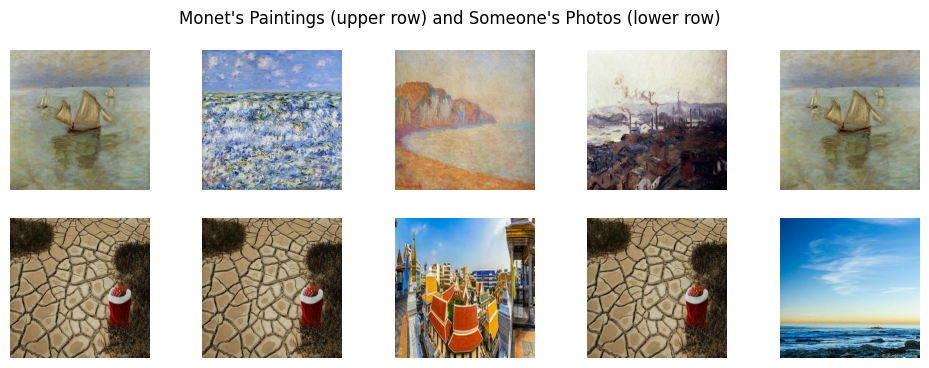

In [6]:
# PLOT SOME PAINTINGS/PHOTOS
plt.figure(figsize=(12, 4))
for i in range(1,6):
    for im in ds_monet.take(5):
        ax = plt.subplot(2, 5, i)
        plt.imshow(im[0].numpy().astype("uint8"))
        plt.axis("off")
#        plt.title(label[0].numpy().astype("uint8"))
        plt.suptitle('Monet\'s Paintings (upper row) and Someone\'s Photos (lower row)')
for i in range(1,6):
    for im in ds_photo.take(5):
        ax = plt.subplot(2, 5, i+5)
        plt.imshow(im[0].numpy().astype("uint8"))
        plt.axis("off")
#        plt.title(label[0].numpy().astype("uint8"))
        plt.suptitle('Monet\'s Paintings (upper row) and Someone\'s Photos (lower row)')

# **BUILDING THE MODEL LAYERS**

## Layers: augmentation, donwsampling, upsampling

<div class="alert alert-block alert-info">
<b>Beyond usual arguments in favor of dataset augmentation:</b>
    
* There is some directionality in image sets
    * trees and buildings are vertical
    * the horizon, lake/see surfaces, etc are horizontal
* Also, there is directionality in the "rules" of painting (perspectives, contrasts, etc), and famous artists often develop their own set of rules
* Meaning - directionality can mess-up the model; we'll add an option to get rid of it
***
<b>Downsampling \& Upsampling:</b>

* the UNET network architecture performs a reduction in image size followed by a symmetrical size expansion, resulting in two "branches"
* at each expansion step the layers are concatenated with those from the symmetrical reduction step
* both sides of the network rely on convolutions with kernels of varying size and number
</div>

In [7]:
# AUGMENTATION
def flip_rot(flip=True,rot=True):
    '''
    Randomly flips the input image around the y axis;
    Randomly rotates the previous image around +/- 20% in the xy plane
    '''
    result = keras.Sequential()
    if flip:
        result.add(layers.RandomFlip("horizontal"))
    if rot:
        result.add(layers.RandomRotation(0.2))
    return result

# DOWN SAMPLING
def downsampler(maps, kernel_size, normalization=True, dropout=True):
    '''
    Builds a layer that scales down the input image by a factor of 0.5 in each dimension with a convolution,
    followed by batch normalization and Leaky ReLU activation.
    '''
    # INITIALIZERS - He NORMAL WITH LEAKYRELU, RANDOM NORMAL FOR NORMALIZATION
    norm_init = tf.random_normal_initializer(0., 0.02)
    # BUILD LAYER
    result = keras.Sequential()
    # DOWNSIZE WITH CONVOLUTION
    result.add(layers.Conv2D(maps, kernel_size, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    # ADD CHANNEL-WISE NORMALIZATION LAYER
    if normalization:
        result.add(layers.GroupNormalization(groups=-1, gamma_initializer=norm_init))
    # DROPOUT
    if dropout:
        result.add(layers.Dropout(0.3))
    result.add(layers.LeakyReLU(alpha=0.2))
    return result

# UP SAMPLING
def upsampler(maps, kernel_size, normalization=True, dropout=True):
    '''
    Builds a layer that scales up the input image by a factor of 2 in each dimension with a convolution,
    followed by batch normalization and Leaky ReLU activation.
    '''
    # INITIALIZERS - He NORMAL WITH LEAKYRELU, RANDOM NORMAL FOR NORMALIZATION
    norm_init = tf.random_normal_initializer(0., 0.02)
    # BUILD LAYER
    result = keras.Sequential()
    # ADD UP-SAMPLING CONVOLUTION LAYER
    result.add(layers.Conv2DTranspose(maps, kernel_size, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    # ADD CHANNEL-WISE NORMALIZATION LAYER
    if normalization:
        result.add(layers.GroupNormalization(groups=-1, gamma_initializer=norm_init))
    # DROPOUT
    if dropout:
        result.add(layers.Dropout(0.3))
    result.add(layers.LeakyReLU(alpha=0.2))
    return result

# **BUILDING THE GAN UNITS**

## Generator: based on UNET

<div class="alert alert-block alert-info">
<b>UNET architecture:</b>
    
* This is a simplified version of UNET, with a smaller number of feature maps and convolution steps
* Still, the principle is the same
    * downsampling to 4x4 feature maps through padded convolutions with kernels from 7x7 to 3x3 size
    * upsampling to 256x256 feature maps through padded convolutions with kernels from 3x3 to 5x5 size (plus final convolution with 5x5 kernel)
    * upsampling feature maps are concatenated with same-sized downsampled maps
* Large kernel sizes are employed to try to capture the characteristic long-range correlations in Monet's "diffuse" style
</div>

In [8]:
def generator():
    # INSTANTIATE INPUT
    inp = layers.Input(shape=[256,256,3])
    xdown= inp
    
    # AUGMENT DATA
    xdown = flip_rot(flip=True,rot=True)(xdown)
    # DOWNSCALE THE PHOTOGRAPHS WITH CONVOLUTIONS; OUTPUT DIMENSIONS ARE (4x4x512)
    downscaling = [downsampler(64,4,normalization=False),downsampler(128,4),downsampler(256,4), downsampler(512,4),downsampler(512,4),downsampler(512,4)]
    samples=[]
    for d in downscaling:
        xdown= d(xdown)
        samples.append(xdown)
    # UPSCALE IMAGES WITH CONVOLUTIONS; OUTPUT IMAGE DIMENSIONS = (256,256,128)
    xup = xdown
    upscaling = [upsampler(512,4),upsampler(512,4),upsampler(256,4),upsampler(128,4),upsampler(64,4)]
    # CREATE LIST OF SAMPLES TO BE CONCATENATED
    selpmas = reversed(samples[:-1])
    for u,s in zip(upscaling, selpmas):
        xup = u(xup)
        xup = layers.Concatenate()([xup,s])
    # UPSAMPLING WITHOUT CONCATENATION; OUTPUT SIZE (256,256,512)
    xup = upsampler(256,4)(xup)
    # TO IMAGE; OUTPUT IMAGE SIZE = (256,256,3)
    # GLOROT INITIALIZER USED HERE, DUE TO TANH ACTIVATION
    xup = layers.Conv2D(3, 3, strides=1, padding='same', kernel_initializer='glorot_normal', activation='tanh')(xup)
    # OUTPUT
    return keras.Model(inputs=inp, outputs=xup)

## Discriminator

<div class="alert alert-block alert-info">
<b>Architecture:</b>
    
* downsample an input painting to a single 32x32 feature maps through padded convolutions with kernels from 7x7 to 3x3 size
* build a final 32x32 evaluation map with a padded convolution (3x3 kernel)
</div>

In [9]:
def discriminator():
    # INSTANTIATE INPUT
    inp = layers.Input(shape=[256,256,3])
    xdown= inp
    
    # DOWNSCALE THE IMAGES WITH CONVOLUTIONS; FINAL DIMENSIONS OF EACH PHOTO IN A 5-PHOTO BATCH ARE (32,32,512)
    downscaling = [downsampler(64,4,normalization=False, dropout=True),downsampler(128,4, dropout=True),downsampler(256,4, dropout=True)]
    # GETTING DOWNSCALED MAPS OF THE PHOTOS
    for d in downscaling:
        xdown= d(xdown)
    # CONVOLUTIONS WITHOUT DOWNSAMPLING (32x32x512)
    xdown = layers.Conv2D(512, 3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False)(xdown)
    #xdown = layers.Dropout(0.5)(xdown)
    xdown = layers.GroupNormalization(groups=-1, gamma_initializer=tf.random_normal_initializer(0., 0.02))(xdown)
    xdown = layers.LeakyReLU(alpha=0.2)(xdown)
    # TO EVALUATION MAP: 32x32x1
    xdown = layers.Conv2D(1, 3, strides=1, padding='same', kernel_initializer='glorot_normal', use_bias=False)(xdown)
    # OUTPUT
    return keras.Model(inputs=inp, outputs=xdown)

# **ASSEMBLING THE GAN**

<div class="alert alert-block alert-info">
<b>The GAN:</b>
    
* Make use of the Keras.Model class to build a GAN class (subclassing from Model)
    * take the generator and discriminator as the model's layers
    * set compile with ADAM optimizer and custom loss functions
    * set forward pass
</div>

## Subclassing a model from Keras

In [10]:
class Gan(keras.Model):
    # MODEL METHODS
    def __init__(self, generator, discriminator):
        super().__init__()
        self.monet_gen = generator
        self.monet_disc = discriminator
        
    # MODEL COMPILATION METHOD FROM KERAS
    # LOSS FUNCTIONS ARE SET IN THE CELL BELOW
    def compile(self, gen_optimizer, disc_optimizer, gen_loss_fn, regen_loss_fn, disc_loss_fn):
        super().compile()
        self.gen_opt = gen_optimizer
        self.disc_opt = disc_optimizer
        self.gen_loss = gen_loss_fn
        self.regen_loss = regen_loss_fn
        self.disc_loss = disc_loss_fn
    
    # CUSTOM MODEL TRAINING
    def train_step(self, data):
        # REMEMBER: BATCHES HAVE SHUFFLE=TRUE
        real_photo, real_monet = data
        # TRAIN DISCRIMINATOR AND GENERATOR
        with tf.GradientTape(persistent=True) as gan_tape:
            # GENERATING MONETS
            pic_to_monet = self.monet_gen(real_photo)
            monet_to_monet = self.monet_gen(real_monet)
            # DISCRIMINATOR EVALUATES BOTH REAL AND FAKE MONETS
            disc_real_monet = self.monet_disc(real_monet)
            disc_fake_monet = self.monet_disc(pic_to_monet)
            # DISCRIMINATOR LOSS
            disc_loss = self.disc_loss(disc_real_monet, disc_fake_monet)
            # GENERATOR LOSS; THE REGEN_LOSS YIELDS A LARGE ENOUGH VALUE TO DRIVE THE 
            # GRADIENT OPTIMIZATION EVEN WHEN THE DISCRIMINATOR IS CONFUSED
            gen_loss = self.gen_loss(disc_fake_monet)
            #regen_loss = self.regen_loss(real_monet, monet_to_monet)
            gen_total_loss = gen_loss# + regen_loss
        # CALCULATE AND APPLY DISCRIMINATOR GRADIENT
        disc_grad = gan_tape.gradient(disc_loss, self.monet_disc.trainable_variables)
        self.disc_opt.apply_gradients(zip(disc_grad, self.monet_disc.trainable_variables))
        # CALCULATE AND APPLY GENERATOR GRADIENT
        gen_grad = gan_tape.gradient(gen_total_loss, self.monet_gen.trainable_variables)
        self.gen_opt.apply_gradients(zip(gen_grad, self.monet_gen.trainable_variables))
        
        # RETURN LOSS VALUES
        #return {"Generator loss": gen_loss, "Regen loss": regen_loss, "Discriminator loss": disc_loss}
        return {"Generator loss": gen_loss, "Discriminator loss": disc_loss}

## Loss Functions

<div class="alert alert-block alert-info">
<b>Loss Functions:</b>
    
* Discriminator loss averages 
    * the comparison (cross-entropy) between a real Monet to the ideal "real" evaluation map from the discriminator (an all=ones matrix)
    * the comparison (cross-entropy) between a generated Monet and the ideal "fake" evaluation map from the discriminator (an all=zeroes matrix)
* Total Generator loss sums
    * Generator loss: the discriminator's evaluation map for a generated Monet compared to an all-ones map (cross-entropy); an all-ones evaluation map from a generated Monet would mean the discriminator is entirely fooled
    * <b>Regen loss was disabled.</b> Regen loss: the mean element-wise absolute difference between a real Monet and a Monet generated from that same real Monet (how well can the generator re-generate an image)
</div>

In [11]:
def disc_loss_function(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5
    
def gen_loss_function(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
def regen_loss_function(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return loss

# **RUNNING THE GAN**

## Scaling the data, caching and prefetching the datasets

In [12]:
# SCALE PHOTOS IN DATASETS
ds_photo = ds_photo.map(layers.Rescaling(scale=1.0 / 127.5, offset=-1), num_parallel_calls=tf.data.AUTOTUNE)
ds_monet = ds_monet.map(layers.Rescaling(scale=1.0 / 127.5, offset=-1), num_parallel_calls=tf.data.AUTOTUNE)

# PERFORMANCE ENHANCEMENT
ds_photo = ds_photo.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
ds_monet = ds_monet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Compile and Fit

In [13]:
%%time
# SET-UP MODEL
model = Gan(discriminator=discriminator(), generator=generator())
# COMPILE MODEL
model.compile(gen_optimizer=keras.optimizers.Adam(learning_rate=0.00004, beta_1=0.5),
                 disc_optimizer=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5),
                 gen_loss_fn=gen_loss_function,
                 regen_loss_fn=regen_loss_function,
                 disc_loss_fn=disc_loss_function)
# FIT MODEL
model.fit(tf.data.Dataset.zip((ds_photo.take(128), ds_monet.take(128))), epochs=20)

Epoch 1/20
128/128 [==============================] - 396s 3s/step - Generator loss: 0.6914 - Discriminator loss: 0.6929
Epoch 2/20
128/128 [==============================] - 377s 3s/step - Generator loss: 0.6909 - Discriminator loss: 0.6926
Epoch 3/20
128/128 [==============================] - 373s 3s/step - Generator loss: 0.6893 - Discriminator loss: 0.6927
Epoch 4/20
128/128 [==============================] - 379s 3s/step - Generator loss: 0.6871 - Discriminator loss: 0.6933
Epoch 5/20
128/128 [==============================] - 376s 3s/step - Generator loss: 0.6881 - Discriminator loss: 0.6939
Epoch 6/20
128/128 [==============================] - 378s 3s/step - Generator loss: 0.6908 - Discriminator loss: 0.6941
Epoch 7/20
128/128 [==============================] - 367s 3s/step - Generator loss: 0.6932 - Discriminator loss: 0.6937
Epoch 8/20
128/128 [==============================] - 369s 3s/step - Generator loss: 0.6934 - Discriminator loss: 0.6938
Epoch 9/20
128/128 [============

<div class="alert alert-block alert-warning">
<b>Current notes on network tweaks and optimization:</b>
    
* discriminator loss decreases very abruptly
    * discriminator learning rate: 4e-5, beta_1=0.5
    * generator learning rate: 1e-5, beta_1=0.5
* disabled the regen loss
    * re-introduced data augmentation
* changed all generator/discriminator upscaling/downscaling kernel sizes to 4x4 in order to avoid checkerboard patterning
* first discriminator downsample without normalization
* introduced channel-wise normalization
* added 0.3 dropout to generator and discriminator
</div>

## Admire the Paintings

16/16 [==============================] - 10s 631ms/step


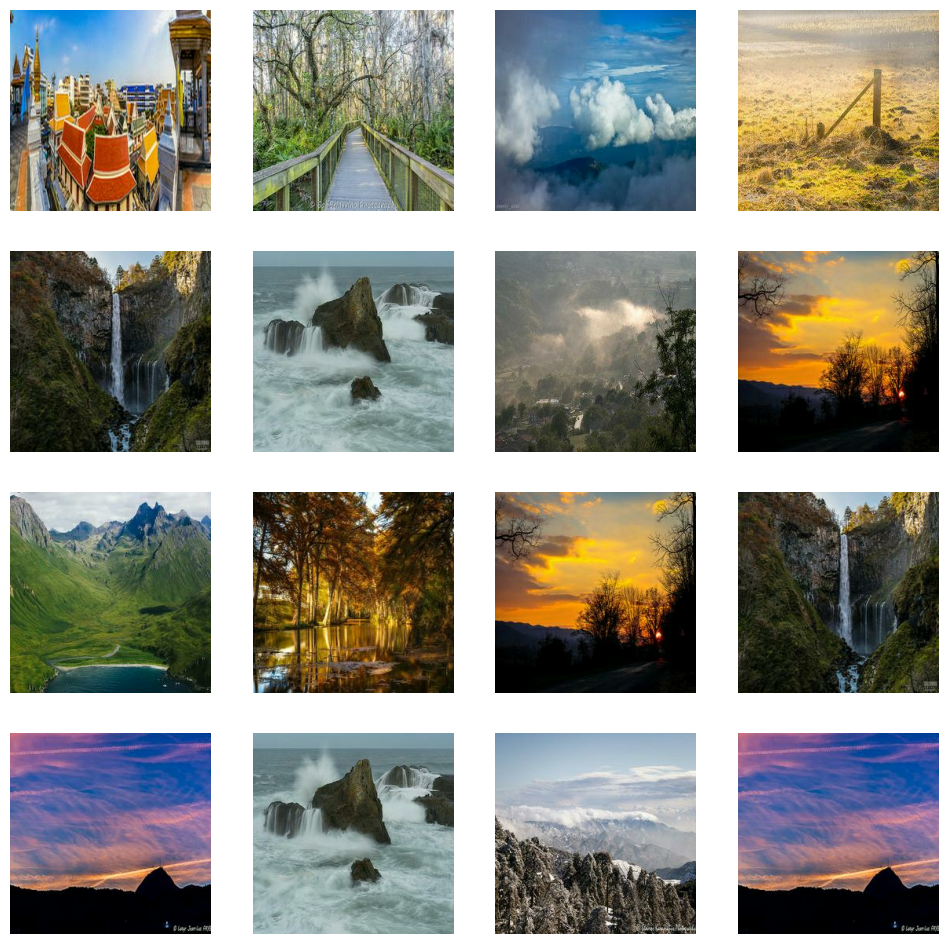

In [19]:
# PLOT MONETIZED PHOTOGRAPHS
trained_gen = model.monet_gen
photos = ds_photo.take(16)
output = trained_gen.predict(photos)
plt.figure(figsize=(12,12))

for i in range(1,17):
    for im in photos:
        ax = plt.subplot(4, 4, i)
        img=(im[0]+1)*127.5
        plt.imshow(img.numpy().astype("uint8"))
        plt.axis("off")